**Data mining Project - University of Pisa, acedemic year 2023/24**
 
**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Nearest Centroid

Nearest Centroid is a classification model which use the mean of the points in the dataset (centroid) to assign labels to observation. Each sample is assigned to the label of the nearest centroid in the feature space.

In [23]:
import pandas as pd
import json
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score
from time import time
from classification_utils import *
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
RESULTS_DIR = '../data/classification_results'
SEED=42
clf_name = 'NearestCentroidClassifier'

We load the dataset and the features used for classification.

In [24]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_distance_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

We display the features names we will use.

In [25]:
print(features_for_clf)
print(f'Number of features: {len(features_for_clf)}')

['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'day_x', 'day_y', 'day_of_week_x', 'day_of_week_y', 'month_x', 'month_y', 'year', 'days_from_first_incident', 'poverty_perc', 'democrat', 'gun_law_rank', 'aggression', 'accidental', 'defensive', 'suicide', 'road', 'house', 'school', 'business', 'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction']
Number of features: 34


We make a 5-fold cross validation in which we check which of the two distance metrics (euclidean and manhattan) has better performance. <br>
The values for training are scaled to be between 0 and 1 so that bigger values in module, and so bigger distances, don't affect the classification.

In [27]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
scaler = MinMaxScaler()
nc = NearestCentroid()
pipe = Pipeline(steps=[('scaler', scaler), ('nc', nc)])

param_grid = {
    'nc__metric': ['euclidean', 'manhattan']
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=-1,
    scoring=make_scorer(f1_score),
    verbose=10,
    cv=cv,
    refit=False
)
gs.fit(indicators_train_df, true_labels_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('nc', NearestCentroid())]),
             n_jobs=-1, param_grid={'nc__metric': ['euclidean', 'manhattan']},
             refit=False, scoring=make_scorer(f1_score), verbose=10)

We display some metrics derived from cross validation fitting.

In [28]:
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df.columns = [col.replace('nc__', '') for col in cv_results_df.columns]
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.152947,0.005822,0.040645,0.005685,euclidean,{'nc__metric': 'euclidean'},0.541679,0.546617,0.536063,0.545965,0.541334,0.542331,0.003802,1
1,0.342333,0.039160,0.051450,0.013780,manhattan,{'nc__metric': 'manhattan'},0.462539,0.466626,0.456401,0.468016,0.454053,0.461527,0.005500,2


We display the mean and standard deviation of the score of the models fitted in the cross validation. These values are calculated on the test set.

In [29]:
params = [col for col in cv_results_df.columns if 'param_' in col and 'random' not in col]
cv_results_df.sort_values(
    by='mean_test_score',
    ascending=False)[params+['std_test_score', 'mean_test_score']].head(20).style.background_gradient(subset=['std_test_score', 'mean_test_score'], cmap='Blues')

,param_metric,std_test_score,mean_test_score
0,euclidean,0.003802,0.542331
1,manhattan,0.005500,0.461527


We make a random oversampling on the positive class such that fatal incidents become 40% of the total number of records. Doing oversampling we can help classifier make better predictions on test set, but we don't reach a 50-50 ratio since it may be unrealistic.

In [30]:
# minority oversampling
indicators_oversampled_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)
indicators_oversampled_train_df = indicators_oversampled_train_df[features_for_clf]
true_oversampled_labels_train = pd.read_csv('../data/clf_y_train_over.csv', index_col=0).values.ravel()

# SMOTE oversampling
indicators_smote_train_df = pd.read_csv('../data/clf_indicators_train_smote.csv', index_col=0)
indicators_smote_train_df = indicators_smote_train_df[features_for_clf]
true_labels_smote_train = pd.read_csv('../data/clf_y_train_smote.csv', index_col=0).values.ravel()

C:\Users\lucam\AppData\Local\Temp\ipykernel_18128\438407527.py:5: DtypeWarning: Columns (11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  indicators_oversampled_train_df = pd.read_csv('../data/clf_indicators_train_over.csv', index_col=0)


We fit the best model we got from cross validation, then we make and save the predictions on test set. Finally we save the models so that we can reuse it without performing the training.

In [31]:
best_index = gs.best_index_
best_model_params = cv_results_df.loc[best_index]['params']
best_model_params = {k.replace('nc__', ''): v for k, v in best_model_params.items()}
best_model = NearestCentroid(**best_model_params)
best_model_oversampled = NearestCentroid(**best_model_params)
best_model_smote = NearestCentroid(**best_model_params)

# scale all the data
minmax_scaler = MinMaxScaler()
indicators_train_scaled = minmax_scaler.fit_transform(indicators_train_df)
indicators_oversampled_train_scaled = minmax_scaler.fit_transform(indicators_oversampled_train_df)
indicators_smote_train_scaled = minmax_scaler.fit_transform(indicators_smote_train_df)
indicators_test_scaled = minmax_scaler.fit_transform(indicators_test_df)


# fit the model on all the training data
fit_start = time()
best_model.fit(indicators_train_scaled, true_labels_train)
fit_time = time()-fit_start

# fit the model on all the training data (oversampled)
fit_start = time()
best_model_oversampled.fit(indicators_oversampled_train_scaled, true_oversampled_labels_train)
fit_time_oversampled = time()-fit_start

# fit the model on all the training data (smote)
fit_start = time()
best_model_smote.fit(indicators_smote_train_scaled, true_labels_smote_train)
fit_time_smote = time()-fit_start


# get the predictions on the training data
train_score_start = time()
pred_labels_train = best_model.predict(indicators_train_scaled)
train_score_time = time()-train_score_start

# get the predictions on the training data (oversampled)
train_score_start = time()
pred_labels_oversampled_train = best_model_oversampled.predict(indicators_oversampled_train_scaled)
train_score_time_oversampled = time()-train_score_start

# get the predictions on the training data (smote)
train_score_start = time()
pred_labels_smote_train = best_model_smote.predict(indicators_smote_train_scaled)
train_score_time_smote = time()-train_score_start


# get the predictions on the test data
test_score_start = time()
pred_labels_test = best_model.predict(indicators_test_scaled)
test_score_time = time()-test_score_start

# get the predictions on the test data (oversampled)
test_score_start = time()
pred_labels_oversampled_test = best_model_oversampled.predict(indicators_test_scaled)
test_score_time_oversampled = time()-test_score_start

# get the predictions on the test data (smote)
test_score_start = time()
pred_labels_smote_test = best_model_smote.predict(indicators_test_scaled)
test_score_time_smote = time()-test_score_start


# save the predictions
pd.DataFrame(
    {'labels': pred_labels_test}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the predictions (oversampled)
pd.DataFrame(
    {'labels': pred_labels_oversampled_test}
).to_csv(f'{RESULTS_DIR}/{clf_name}_oversampled_preds.csv')

# save the predictions (smote)
pd.DataFrame(
    {'labels': pred_labels_smote_test}
).to_csv(f'{RESULTS_DIR}/{clf_name}_smote_preds.csv')


# save the model
file = open(f'{RESULTS_DIR}/{clf_name}.pkl', 'wb')
pickle.dump(obj=best_model, file=file)
file.close()

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_oversampled.pkl', 'wb')
pickle.dump(obj=best_model_oversampled, file=file)
file.close()

# save the model
file = open(f'{RESULTS_DIR}/{clf_name}_smote.pkl', 'wb')
pickle.dump(obj=best_model_smote, file=file)
file.close()

# save the cv results
best_model_cv_results = pd.DataFrame(cv_results_df.iloc[best_index]).T
best_model_cv_results.index = [clf_name]
best_model_cv_results.to_csv(f'{RESULTS_DIR}/{clf_name}_train_cv_scores.csv')

We display some classification scores in order to have some metrics useful to make comparisions with other models. These scores are refearing to predictions on training and test set including oversampled and smote.

In [32]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=best_model_params,
    prob_pred=None,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NearestCentroidClassifier,0.799725,0.631119,0.705488,0.458887,0.664348,0.542826,0.629306,0.647733,0.624157,0.690611,0.641757,0.653414,0.641757,None,0.023999,0.02,{'metric': 'euclidean'}


In [33]:
compute_clf_scores(
    y_true=true_oversampled_labels_train,
    y_pred=pred_labels_oversampled_train,
    train_time=fit_time_oversampled,
    score_time=train_score_time_oversampled,
    params=best_model_params,
    prob_pred=None,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_oversampled_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NearestCentroidClassifier,0.737736,0.634378,0.682164,0.546807,0.66172,0.5988,0.642271,0.648049,0.640482,0.661364,0.645315,0.648818,0.645315,None,0.030996,0.024639,{'metric': 'euclidean'}


In [34]:
compute_clf_scores(
    y_true=true_labels_smote_train,
    y_pred=pred_labels_smote_train,
    train_time=fit_time_smote,
    score_time=train_score_time_smote,
    params=best_model_params,
    prob_pred=None,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_smote_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NearestCentroidClassifier,0.779625,0.605081,0.681352,0.556544,0.743444,0.636559,0.668084,0.674263,0.658955,0.690393,0.660426,0.663435,0.660426,None,0.029001,0.021177,{'metric': 'euclidean'}


In [35]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=best_model_params,
    prob_pred=None,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NearestCentroidClassifier,0.798693,0.629253,0.70392,0.457179,0.663165,0.541236,0.627936,0.646209,0.622578,0.689367,0.640109,0.651841,0.640109,None,0.023999,0.011002,{'metric': 'euclidean'}


In [36]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_oversampled_test,
    train_time=fit_time_oversampled,
    score_time=train_score_time_oversampled,
    params=best_model_params,
    prob_pred=None,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_oversampled_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NearestCentroidClassifier,0.797347,0.63283,0.705626,0.457799,0.658408,0.540076,0.627573,0.645619,0.622851,0.68865,0.641018,0.65263,0.641018,None,0.030996,0.024639,{'metric': 'euclidean'}


In [37]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    train_time=fit_time_smote,
    score_time=train_score_time_smote,
    params=best_model_params,
    prob_pred=None,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_smote_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
NearestCentroidClassifier,0.808722,0.600608,0.689299,0.451529,0.698303,0.548435,0.630125,0.649456,0.618867,0.694376,0.631883,0.644205,0.631883,None,0.029001,0.021177,{'metric': 'euclidean'}


Since the model with better performance (better f1-score macro) is the one trained on oversampled data, we will use it for further analisys.

We plot the diffusion matrix in orther to know what is the balancing between false positves, false negatives, true positives and true negatives.

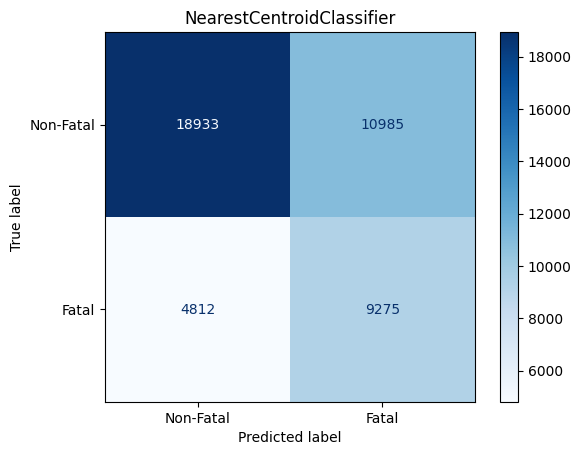

In [43]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_oversampled_test,
    title=clf_name
)

We plot the classification labels in the bidimensional feature spaces obtained pairing 4 features: **aggression**, **drug_alcohol**, **gun_law_rank** and **n_males**.

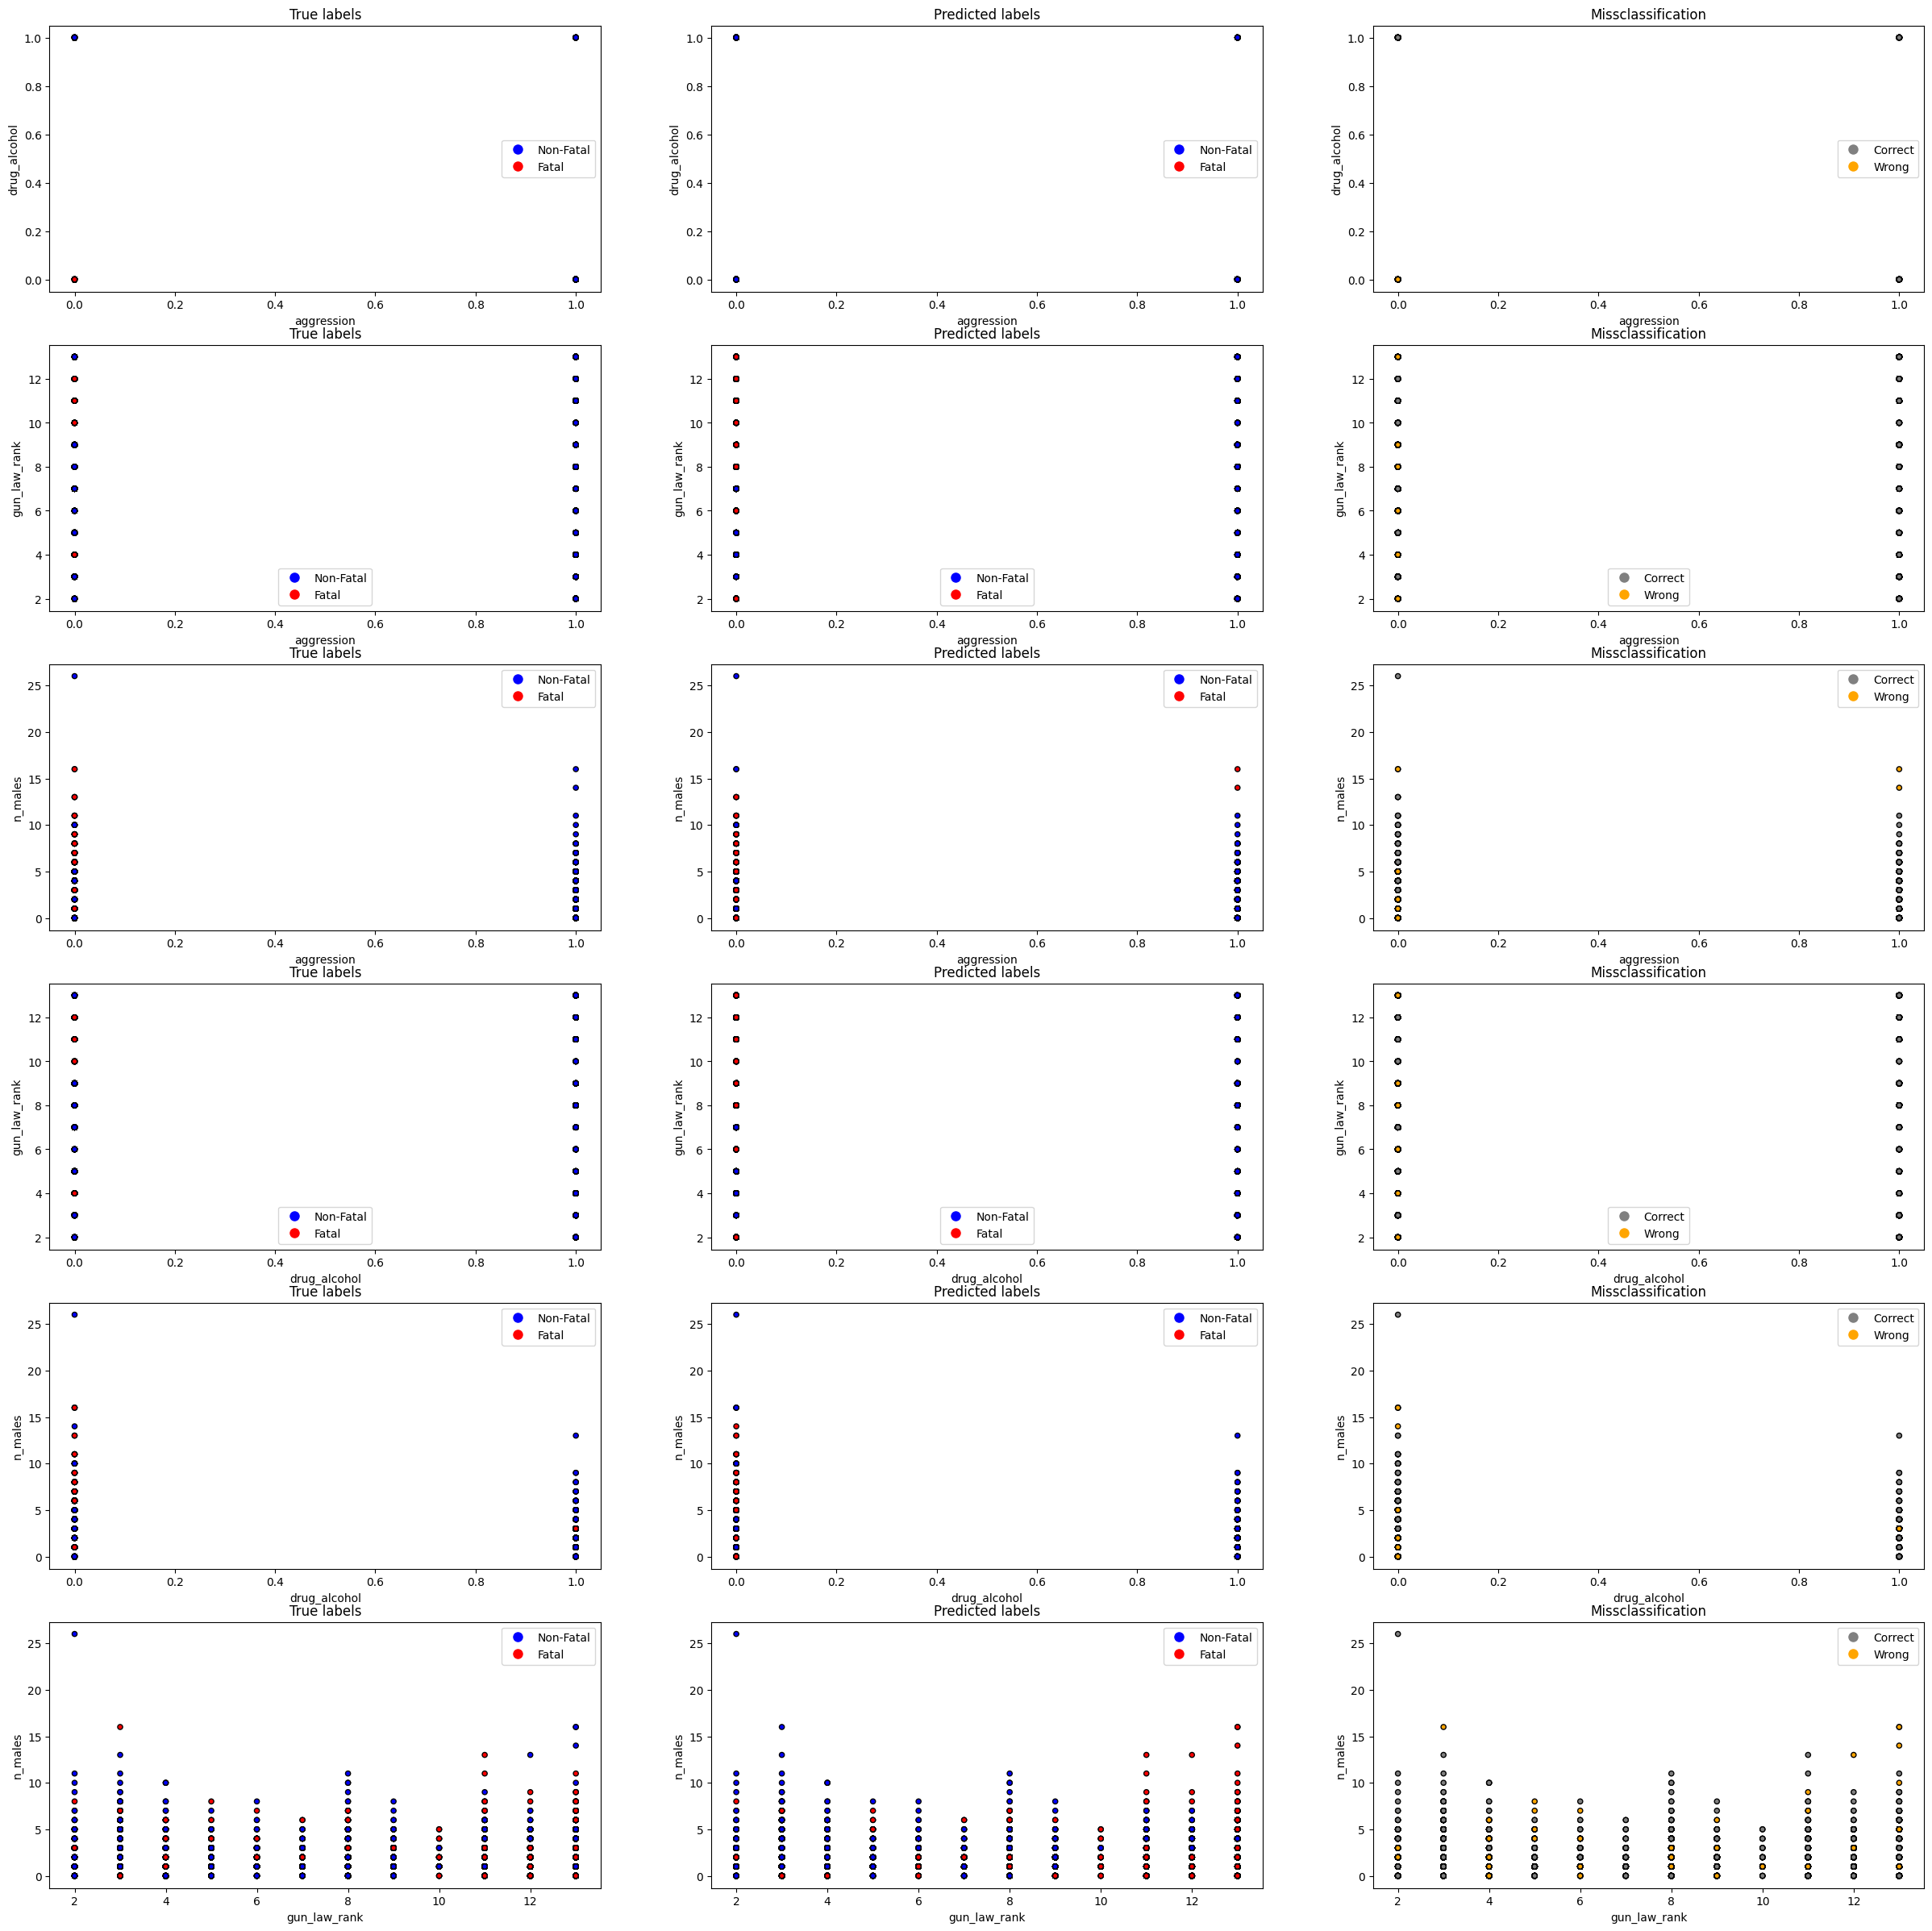

In [44]:
plot_predictions_in_features_space(
    df=incidents_test_df,
    features=['aggression', 'drug_alcohol', 'gun_law_rank', 'n_males'],
    true_labels=true_labels_test,
    pred_labels=pred_labels_oversampled_test,
    figsize=(30, 30)
)

Given the plot, although we can't deduce anything on the separation of clusters, we can notice that when **aggression** and **drug_alcohol** are set to 1, the incidents are not fatal, and the model tends to predict them well.

We permorm PCA and we plot the decision boundary of the first two components.

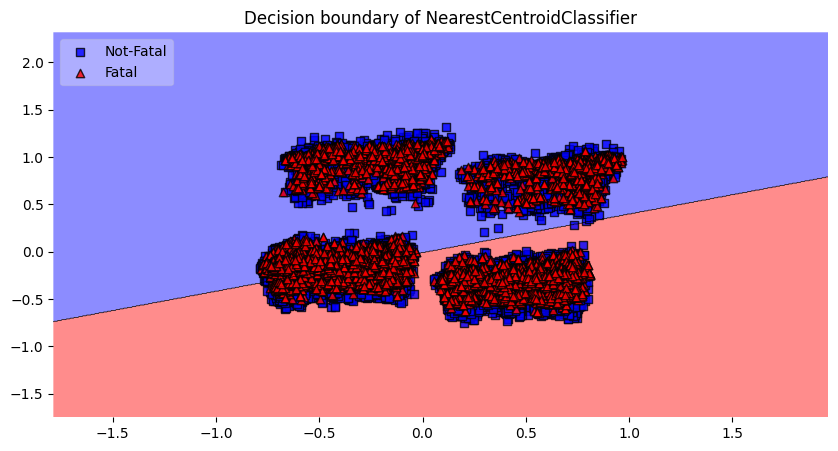

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_PCA_decision_boundary(
  train_set=indicators_oversampled_train_scaled,
  features=indicators_train_df.columns,
  train_label=true_oversampled_labels_train,
  classifier=best_model_oversampled,
  classifier_name=clf_name,
  axs=axs
)

As we expected we got a very simple decision boundary, since the two regions are separated by a straight line.

We plot the learning curve of the model. Each time we perform training in a subsample of the dataset and see how the results vary.

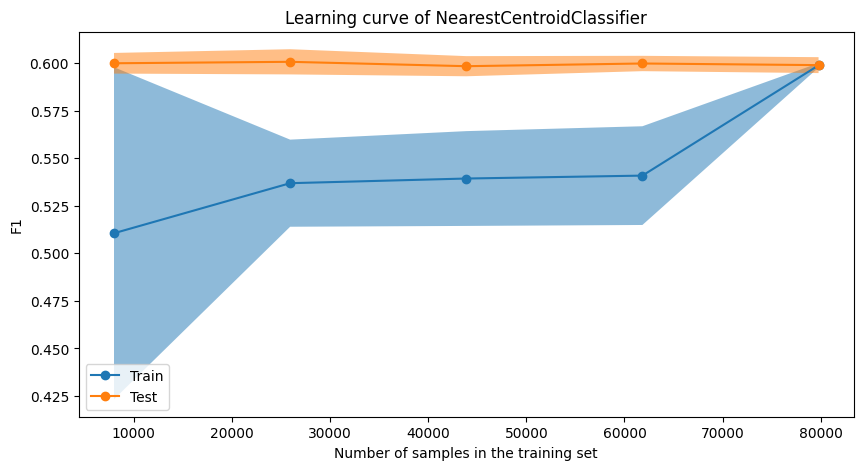

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_learning_curve(
    classifier=best_model_oversampled,
    classifier_name=clf_name,
    train_set=indicators_oversampled_train_scaled,
    labels=true_oversampled_labels_train,
    ax=axs,
    train_sizes=np.linspace(0.1, 1.0, 5),
    metric='f1'
)

We notice that the model has a better performance on test than on train. The curve of the test score is pretty stable around 0.6 and has a small standard deviation, while the training curve has some big improvements, both on F1-score and standard deviation, as the training set increase. 

We display with different types of plot the distribution of the values of the miscassified incidents of **n_killed**, **suicide**, **aggression**, **road** and **location_imp**.

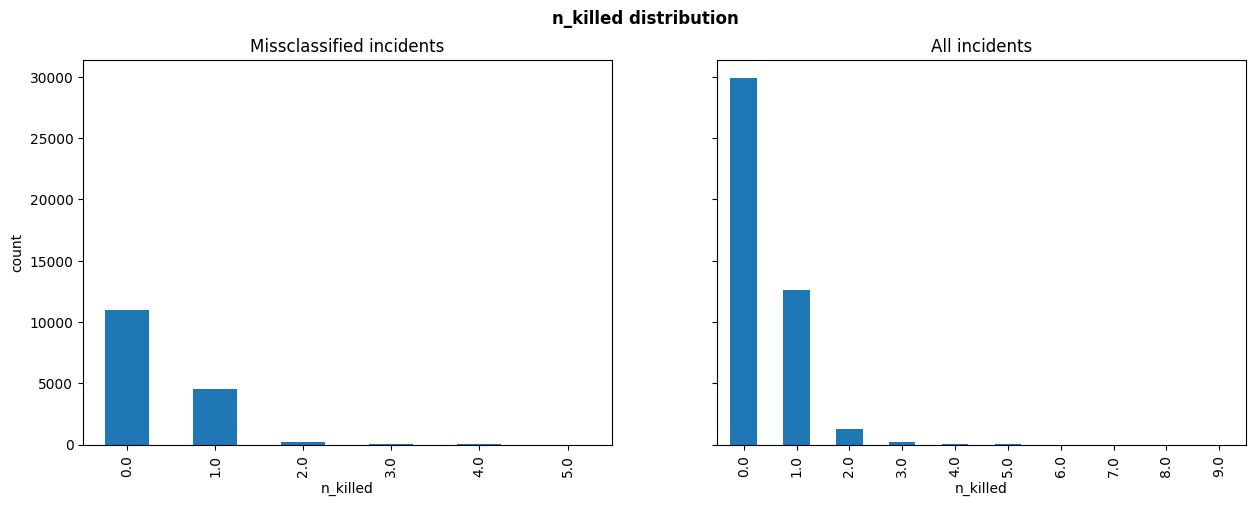

In [50]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_oversampled_test,
    incidents_test_df,
    'n_killed',
    'bar',
    title='n_killed distribution'
)

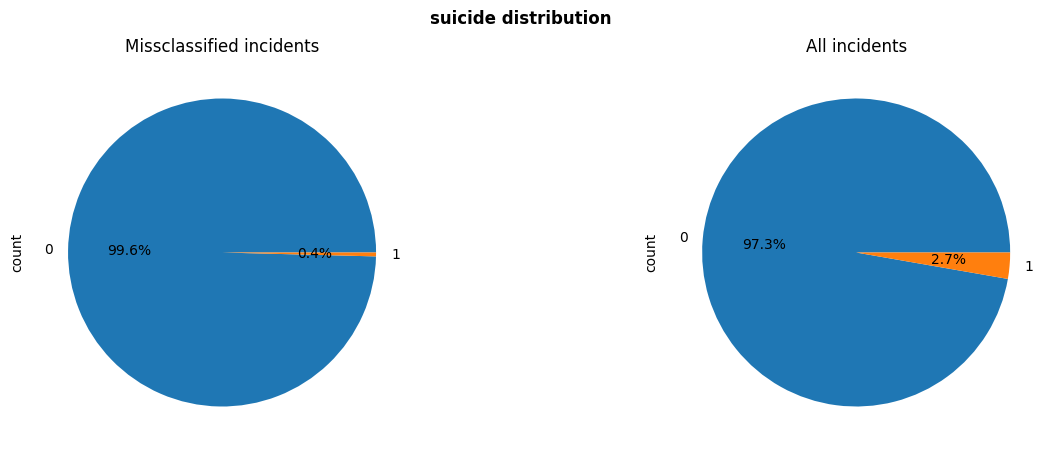

In [51]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_oversampled_test,
    incidents_test_df,
    'suicide',
    'pie',
    title='suicide distribution'
)

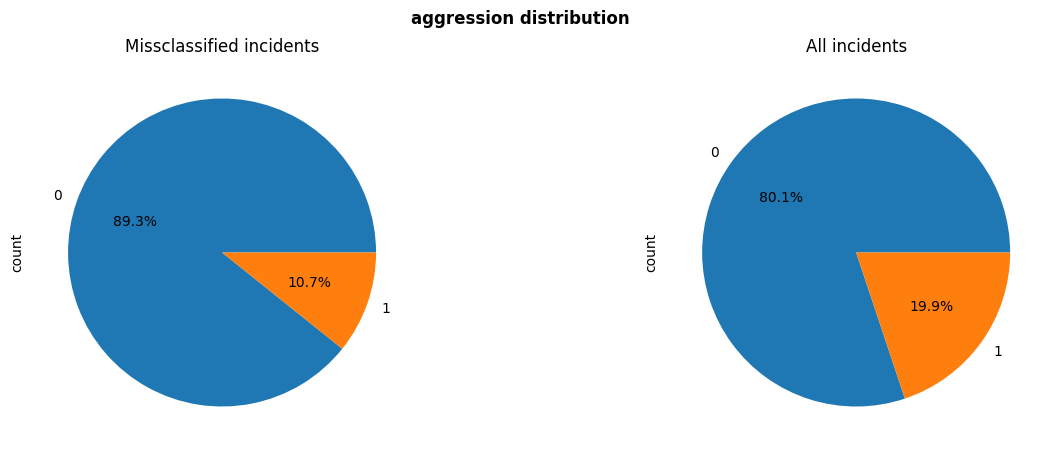

In [52]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_oversampled_test,
    incidents_test_df,
    'aggression',
    'pie',
    title='aggression distribution'
)

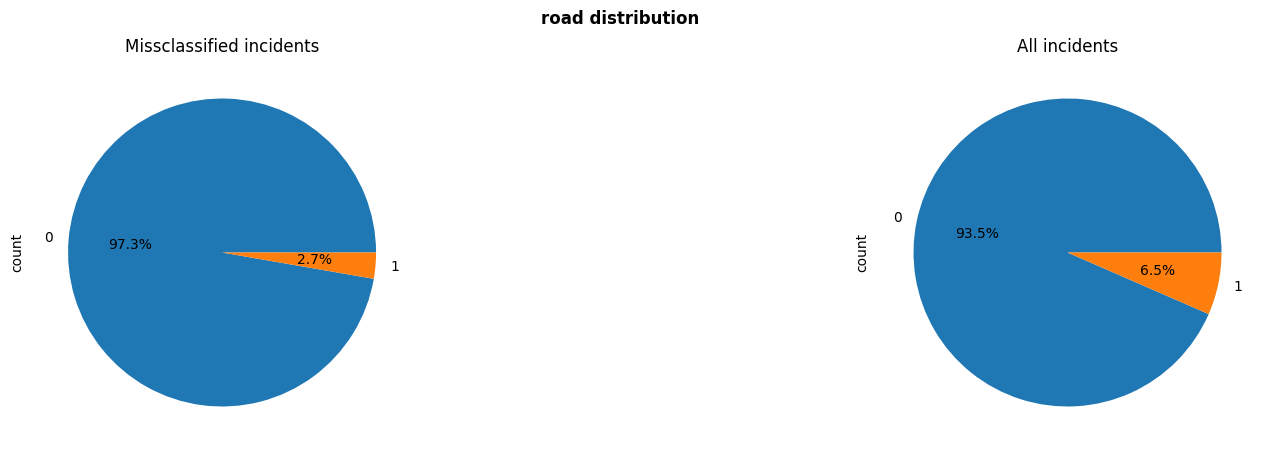

In [53]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_oversampled_test,
    incidents_test_df,
    'road',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5),
    title='road distribution'
)

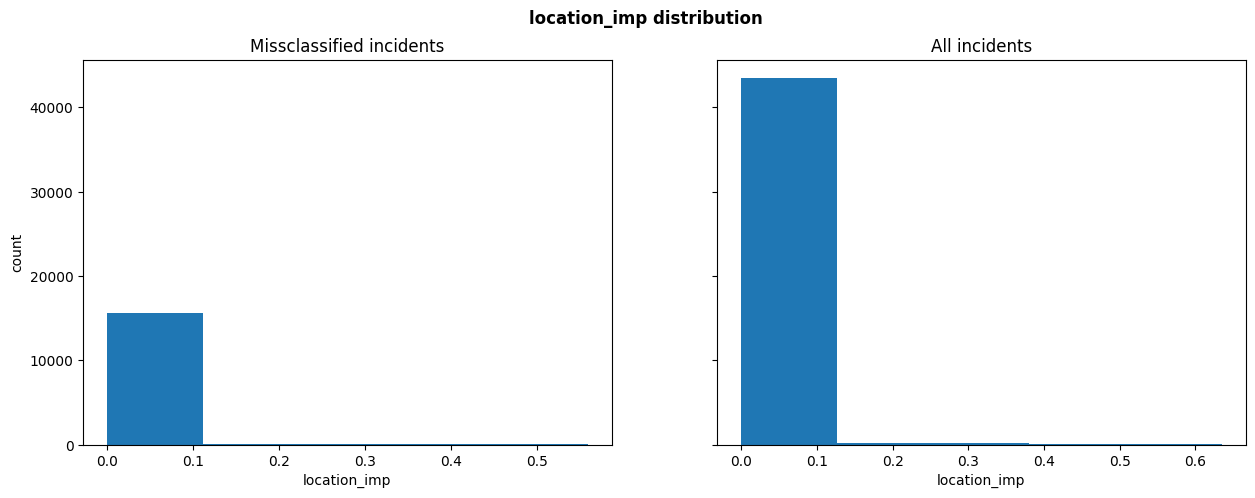

In [54]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_oversampled_test,
    incidents_test_df,
    'location_imp',
    'hist',
    bins=5,
    title='location_imp distribution'
)

We can notice that for **location_imp** and **n_killed** we have similar distribuition shapes. For **road**, **aggression**  and **suicide** we have that the percentage of misclassified incidents with the tag set to True is less than the one on the entire dataset, in particular there are very few miscassified incidents with **suicide** tag set to true.

## Final considerations
The advantage of Nearest Centroid is that is one of the simplest distance based model for classification, on the other hand it's difficult to have good performance on non-trivial dataset like the one of our case study. So, better performance are possible with more complex models.